# Energy Consumption Forecasting
***
## Table of Contents
***

In [82]:
import torch
import os
import random
from torch import nn
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np
from typing import List
import pandas as pd
import seaborn as sns
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

## 1. Introduction

## 2. Device Agnostic-Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

In [83]:
# Set device
# device = "cuda" if torch.cuda.is_available() else "cpu"  # For Windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # For Mac
device

device(type='mps')

## 3. Loading Dataset
Retrieved from [Kaggle - Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

In [84]:
df = pd.read_csv(
    "_datasets/energy_consumption_pjm/AEP_hourly.csv",
    parse_dates=["Datetime"],
    index_col="Datetime",
)
df.rename(columns={df.columns[0]: "Energy_Consumption_MW"}, inplace=True)

In [85]:
print("=" * 50)
print(df.head())
print("=" * 50)
print(f"Shape of the dataset: {df.shape}")
print("=" * 50)
print(df.info())
print("=" * 50)
print(f"Count of null values: {df.isnull().sum().sum()}")
print("=" * 50)
print(df.describe())

                     Energy_Consumption_MW
Datetime                                  
2004-12-31 01:00:00                13478.0
2004-12-31 02:00:00                12865.0
2004-12-31 03:00:00                12577.0
2004-12-31 04:00:00                12517.0
2004-12-31 05:00:00                12670.0
Shape of the dataset: (121273, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Energy_Consumption_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB
None
Count of null values: 0
       Energy_Consumption_MW
count          121273.000000
mean            15499.513717
std              2591.399065
min              9581.000000
25%             13630.000000
50%             15310.000000
75%             17200.000000
max             25695.000000


## Feature Engineering

In [86]:
df["Year"] = df.index.year
df["Date"] = df.index.date
df["Month"] = df.index.month
df["Dayofweek"] = df.index.dayofweek
df["Day"] = df.index.day_name()
df = df.sort_index()

df.head()

,Energy_Consumption_MW,Year,Date,Month,Dayofweek,Day
Datetime,,,,,,
2004-10-01 01:00:00,12379.0,2004,2004-10-01,10,4,Friday
2004-10-01 02:00:00,11935.0,2004,2004-10-01,10,4,Friday
2004-10-01 03:00:00,11692.0,2004,2004-10-01,10,4,Friday
2004-10-01 04:00:00,11597.0,2004,2004-10-01,10,4,Friday
2004-10-01 05:00:00,11681.0,2004,2004-10-01,10,4,Friday


In [ ]:
plt.figure(figsize=(7, 5))
sns.lineplot(df, x="Year", y="Energy_Consumption_MW")
plt.title("Average Energy Consumption Per Year")
plt.ylabel("Energy Consumption (MW)")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

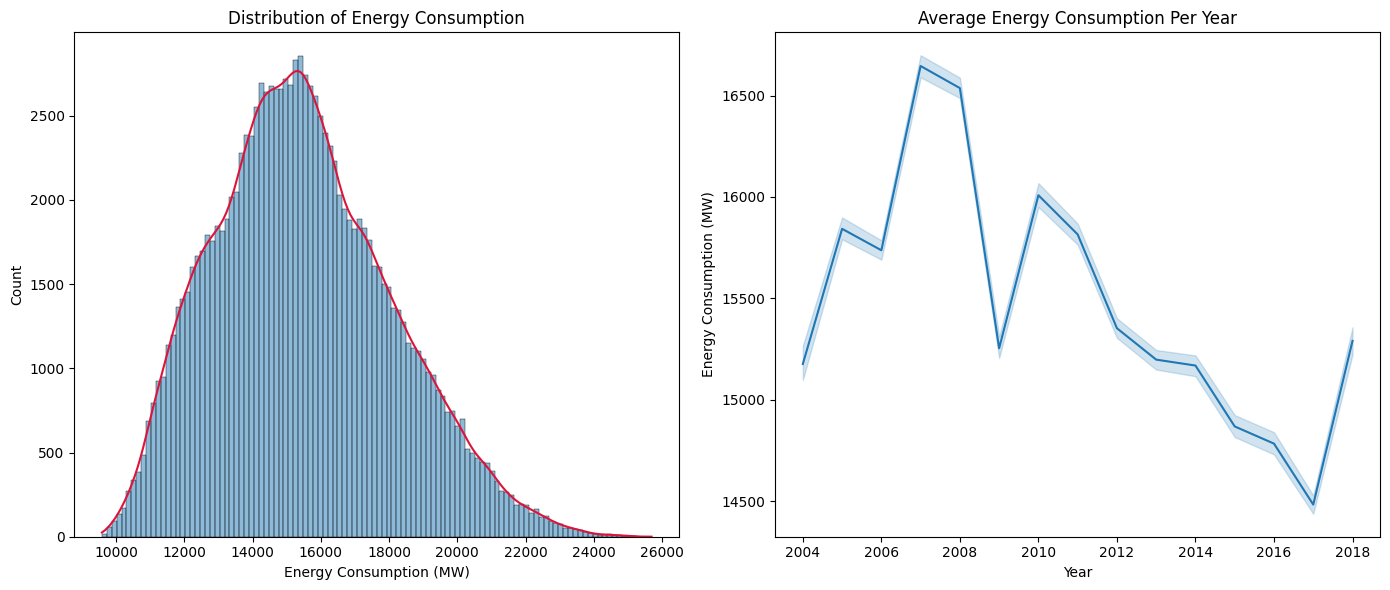

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.histplot(df["Energy_Consumption_MW"], kde=True, edgecolor="black", ax=axes[0])
axes[0].lines[0].set_color("crimson")
axes[0].set_title("Distribution of Energy Consumption")
axes[0].set_xlabel("Energy Consumption (MW)")
sns.lineplot(df, x="Year", y="Energy_Consumption_MW")
axes[1].set_title("Average Energy Consumption Per Year")
axes[1].set_ylabel("Energy Consumption (MW)")
axes[1].set_xlabel("Year")
plt.tight_layout()
plt.show()

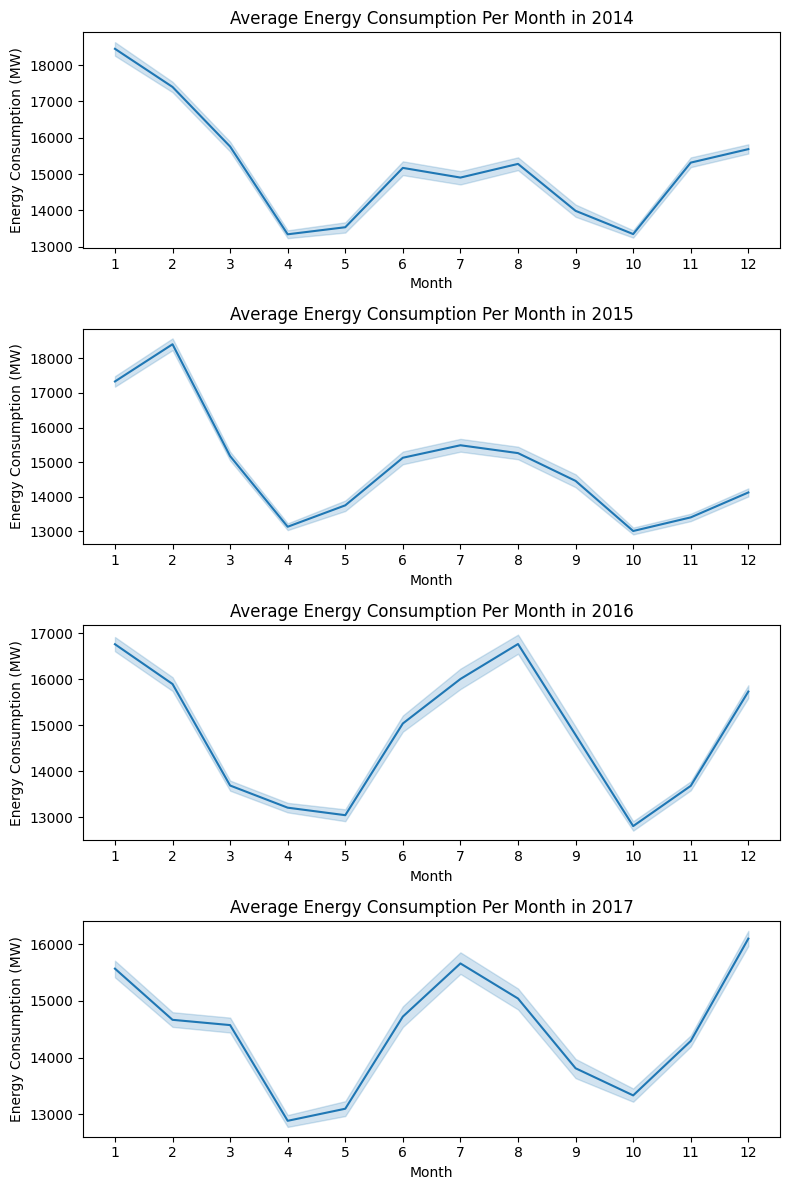

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

years = [2014, 2015, 2016, 2017]
n_figures = len(years)

fig, axes = plt.subplots(nrows=n_figures, ncols=1, figsize=(8, 12))

for i, year in enumerate(years):
    ax = axes[i]
    df_year = df[df["Year"] == year]
    sns.lineplot(data=df_year, x="Month", y="Energy_Consumption_MW", ax=ax)
    ax.set_title(f"Average Energy Consumption Per Month in {year}")
    ax.set_ylabel("Energy Consumption (MW)")
    ax.set_xlabel("Month")
    ax.set_xticks(range(1, 13))

plt.tight_layout()
plt.show()
